In [126]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import ntpath
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imgaug import augmenters as iaa

In [127]:
import torch
from torch import nn

In [128]:
colums = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
dataset = pd.read_csv(filepath_or_buffer="Data/driving_log.csv", names=colums)

In [129]:
dataset.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [130]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

dataset["center"] = dataset["center"].apply(path_leaf)
dataset["left"] = dataset["left"].apply(path_leaf)
dataset["right"] = dataset["right"].apply(path_leaf)

In [131]:
dataset.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [132]:
len(dataset), dataset.shape

(4053, (4053, 7))

<BarContainer object of 25 artists>

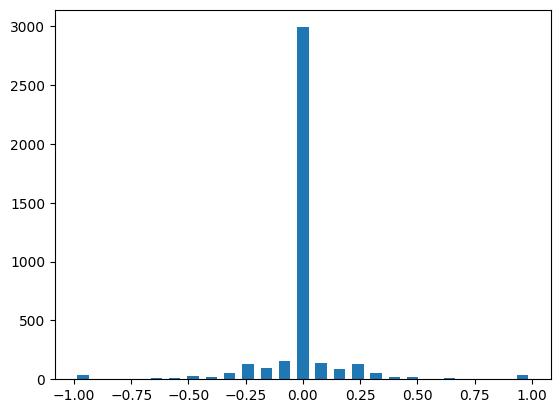

In [133]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(dataset["steering"], num_bins)
center = (bins[:-1] + bins[1:])*0.5
plt.bar(center, hist, width=0.05)

In [134]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(dataset["steering"])):
        if dataset["steering"][i] > bins[j] and dataset["steering"][i] < bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
len(remove_list)

2590

In [135]:
dataset.drop(dataset.index[remove_list], inplace=True)
len(dataset)

1463

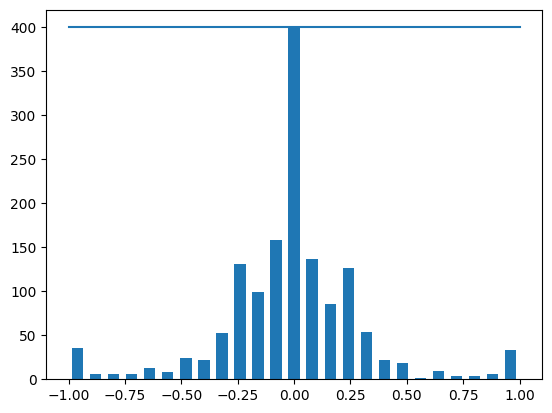

In [136]:
hist, _ = np.histogram(dataset["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(dataset['steering']), np.max(dataset['steering'])), (samples_per_bin, samples_per_bin))

In [137]:
def load_img_steering(datadir, dataset):
    image_path = []
    steering = []
    for i in range(len(dataset)):
        indexed_data = dataset.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3] + 0.15))
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3] - 0.15))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [138]:
datadir = "Data"

In [139]:
image_paths, steerings = load_img_steering(datadir= datadir + "/IMG", dataset=dataset)

In [140]:
image_paths

array(['Data/IMG\\center_2018_07_16_17_11_44_413.jpg',
       'Data/IMG\\left_2018_07_16_17_11_44_413.jpg',
       'Data/IMG\\right_2018_07_16_17_11_44_413.jpg', ...,
       'Data/IMG\\center_2018_07_16_17_16_32_161.jpg',
       'Data/IMG\\left_2018_07_16_17_16_32_161.jpg',
       'Data/IMG\\right_2018_07_16_17_16_32_161.jpg'], dtype='<U43')

In [141]:
steerings

array([-0.05,  0.1 , -0.2 , ...,  0.  ,  0.15, -0.15])

In [142]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

Text(0.5, 1.0, 'Validation set')

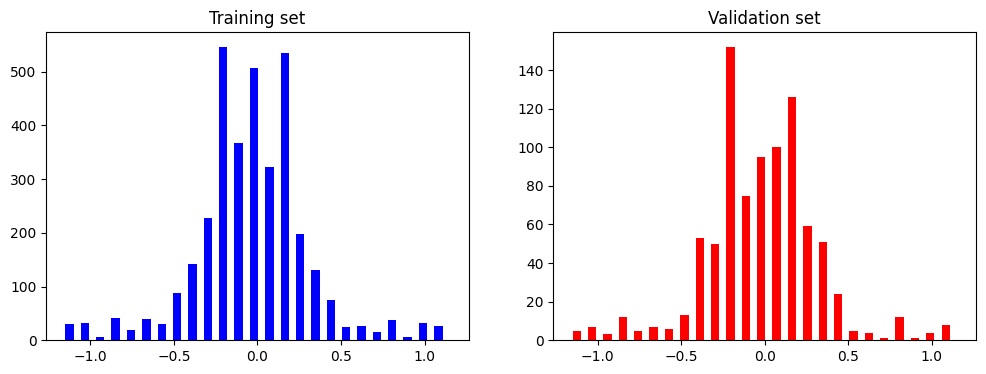

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title("Validation set")

Text(0.5, 1.0, 'Zoomed image')

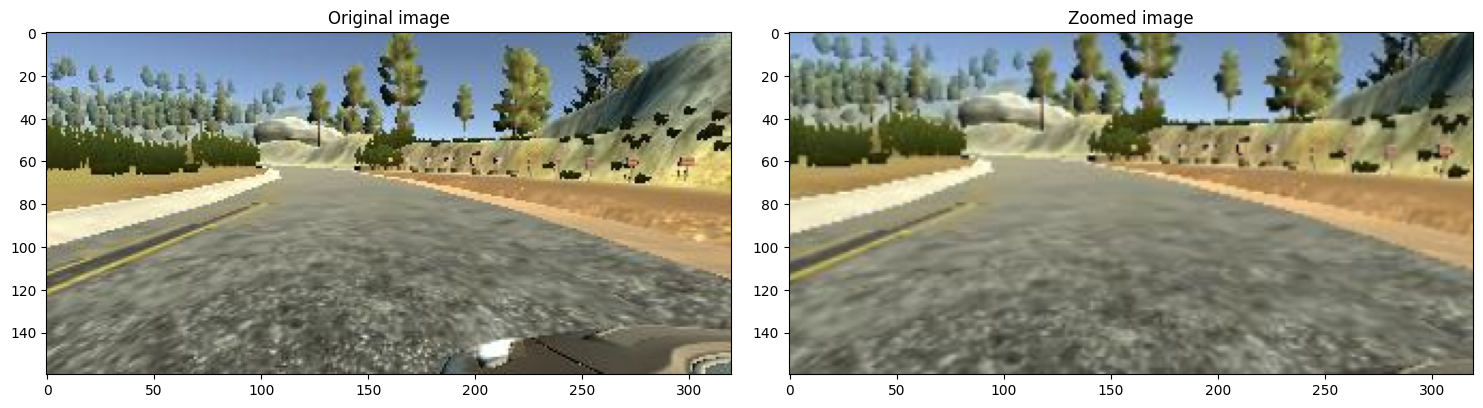

In [144]:
def zoom(img):
    img_zoom = iaa.Affine(scale=(1, 1.3))
    img = img_zoom.augment_image(img)
    return img

image = random.choice(image_paths)
original_image = mpimg.imread(image)
zoomed_img = zoom(original_image)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
fig.tight_layout()

ax[0].imshow(original_image)
ax[0].set_title("Original image")

ax[1].imshow(zoomed_img)
ax[1].set_title("Zoomed image")

Text(0.5, 1.0, 'Panned image')

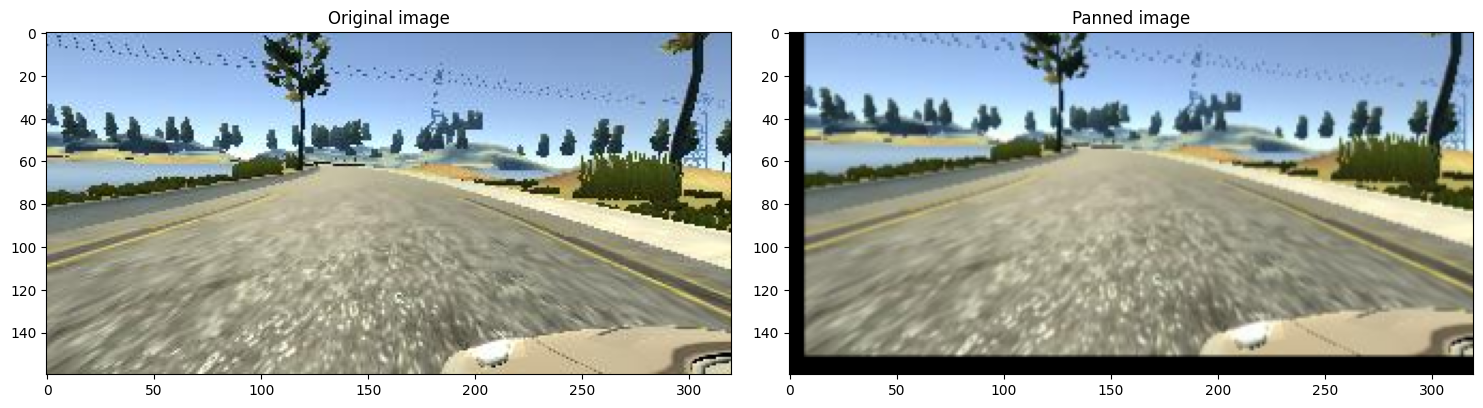

In [145]:
def pan(img):
    pan_img = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    image = pan_img.augment_image(img)
    return image

image = random.choice(image_paths)
original_image = mpimg.imread(image)
panned_img = pan(original_image)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
fig.tight_layout()

ax[0].imshow(original_image)
ax[0].set_title("Original image")

ax[1].imshow(panned_img)
ax[1].set_title("Panned image")

Text(0.5, 1.0, 'Brightness altered image ')

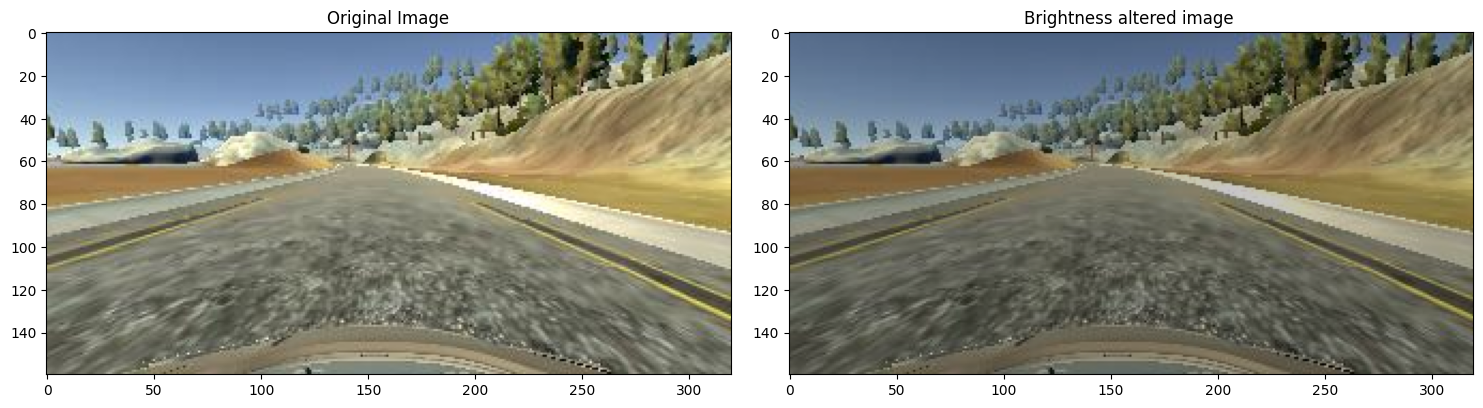

In [146]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

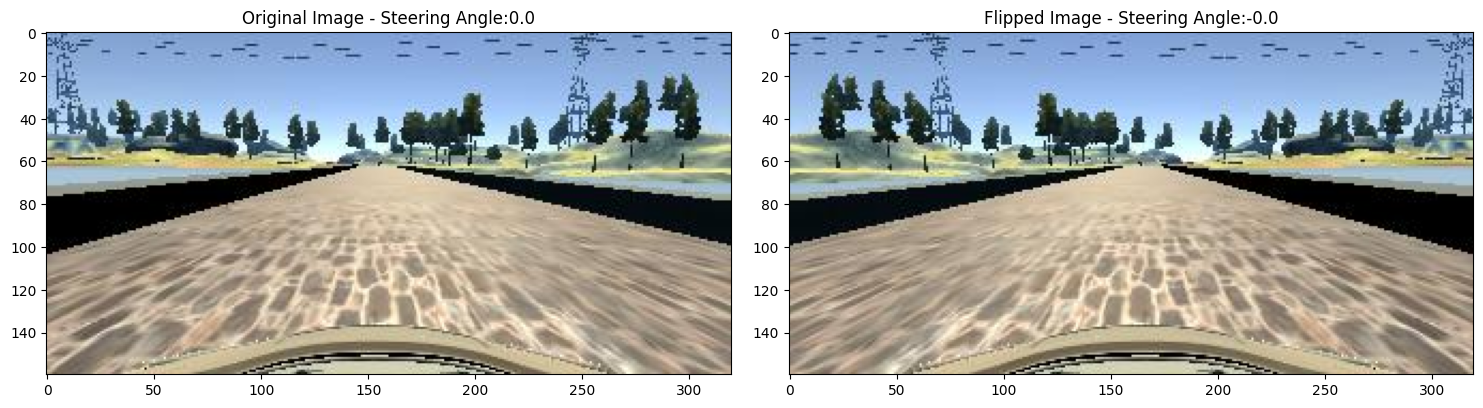

In [147]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [148]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [149]:
def image_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed image')

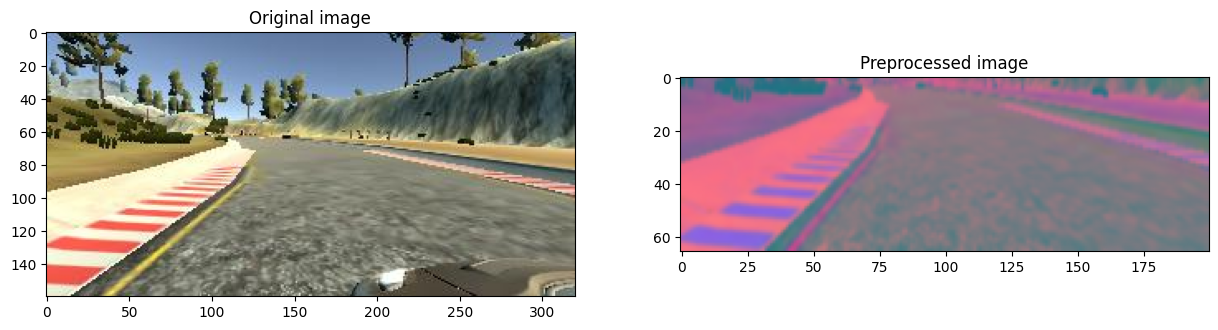

In [150]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image  = image_preprocess(original_image)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title("Original image")
axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed image")

In [151]:
!nvidia-smi

Thu Mar  7 10:14:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.27                 Driver Version: 532.27       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0                9W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [152]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = image_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation image')

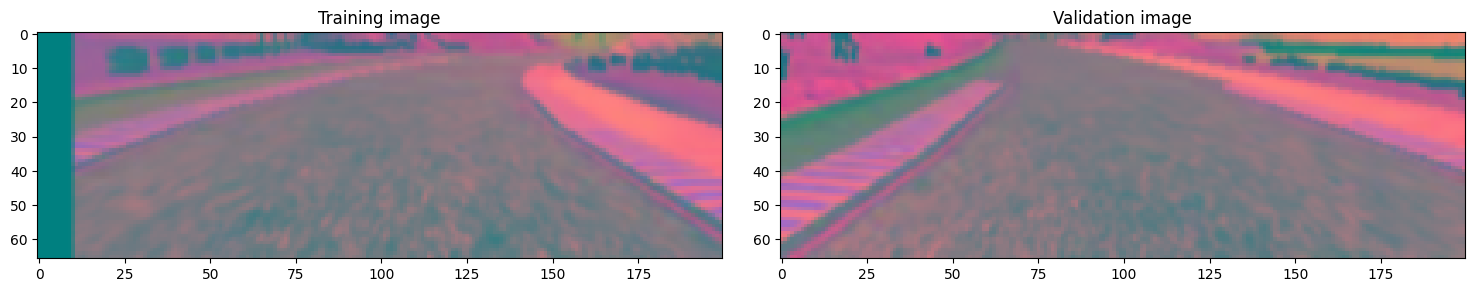

In [153]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation image")

In [154]:
# import torch
# from torch import nn
# from torchvision import transforms

In [155]:
# transform = transforms.Compose([transforms.ToTensor()])

In [156]:
# class nvidia_model(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.conv_block = nn.Sequential(
#             nn.Conv2d(in_channels=3,
#                       out_channels=24,
#                       kernel_size=(5, 5),
#                       stride=(2, 2),
#                       padding=0),
#             nn.ELU(),
#             nn.Conv2d(in_channels=24,
#                       out_channels=36,
#                       kernel_size=(5, 5),
#                       stride=(2, 2),
#                       padding=0),
#             nn.ELU(),
#             nn.Conv2d(in_channels=36,
#                       out_channels=48,
#                       kernel_size=(5, 5),
#                       stride=(2, 2),
#                       padding=0),
#             nn.ELU(),
#             nn.Conv2d(in_channels=48,
#                       out_channels=64,
#                       kernel_size=(5, 5)),
#             nn.ELU()
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=18*64,
#                       out_features=100),
#             nn.ELU(),
#             nn.Linear(in_features=100,
#                       out_features=50),
#             nn.ELU(),
#             nn.Linear(in_features=50,
#                       out_features=10),
#             nn.ELU(),
#             nn.Linear(in_features=10,
#                       out_features=1)
#         )
        
#     def forward(self, x):
#         x = self.conv_block(x)
#         x = torch.flatten(x)
#         return self.classifier(x)

In [157]:
# img = transform(x_train_gen[0])

In [158]:
# model = nvidia_model()

In [159]:
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(params=model.parameters(),
#                              lr=0.001)

In [160]:
# img = img.to(torch.float32)

In [161]:
# model(img)

In [162]:
# x_train_gen = torch.from_numpy(x_train_gen)

In [163]:
# a = x_train_gen.squeeze()
# a.shape

In [164]:
# plt.imshow(a)

In [165]:
# train_batch = batch_generator(X_train, y_train, 1000, 1)
# train_batch
# x_train, y_train = next(train_batch)
# x_train, y_train

In [166]:
# x_train.shape, y_train.shape

In [167]:
# test_batch = batch_generator(X_valid, y_valid, 20, 0)
# x_test, y_test = next(test_batch)
# x_test, y_test

In [168]:
# import torchmetrics
# from torchmetrics import Accuracy

In [169]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device

In [170]:
# if torch.cuda.is_available():
#     model.cuda()

In [171]:
# x_train

In [172]:
# X_train = torch.from_numpy(x_train)

In [173]:
# X_train = X_train.permute(0, 3, 1, 2)
# X_train.shape

In [174]:
# X_train.dtype

In [175]:
# X_train = X_train.to(torch.float32).to(device="cuda:0")

In [176]:
# y_train = torch.from_numpy(y_train)

In [177]:
# y_train = y_train.to(torch.float32).to(device="cuda:0")

In [178]:
# from tqdm.auto import tqdm

In [179]:
# def train_step(X_train, y_train,
#                loss_fn: torch.nn.Module,
#                optimizer: torch.optim.Optimizer,
#                epochs: int,
#                device: torch.device = "cuda:0"):
#     for epoch in tqdm(range(epochs)):
#         print(f"Look at epoch {epoch}")
#         for i in range(len(X_train)):
#             X_train[i], y_train[i] = X_train[i].to(device), y_train[i].to(device)
#             model.train()
#             optimizer.zero_grad()
#             y_pred = model(X_train[i])
#             loss = loss_fn(y_pred, y_train[i])
#             print(f"Train loss: {loss}")
#             loss.backward()
#             optimizer.step()
#             model.eval()

In [180]:
# train_step(X_train=X_train, y_train=y_train,
#            loss_fn=loss_fn,
#            optimizer=optimizer,
#            epochs=3,
#            device=device)

In [181]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D

In [182]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  # model.add(Conv2D(64, (3,3), activation='elu'))
#   model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_15 (Conv2D)          (None, 1, 18, 64)         76864     
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_12 (Dense)            (None, 100)               115300    
                                                                 
 dense_13 (Dense)            (None, 50)               

In [183]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

C:\Users\HoangLee\AppData\Local\Temp\ipykernel_9240\2113613756.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 140s 465ms/step - loss: 0.2247 - val_loss: 0.0618
Epoch 2/10
300/300 [==============================] - 124s 414ms/step - loss: 0.0744 - val_loss: 0.0580
Epoch 3/10
300/300 [==============================] - 111s 371ms/step - loss: 0.0680 - val_loss: 0.0515
Epoch 4/10
300/300 [==============================] - 118s 394ms/step - loss: 0.0592 - val_loss: 0.0468
Epoch 5/10
300/300 [==============================] - 166s 555ms/step - loss: 0.0573 - val_loss: 0.0506
Epoch 6/10
300/300 [==============================] - 164s 549ms/step - loss: 0.0518 - val_loss: 0.0374
Epoch 7/10
300/300 [==============================] - 163s 545ms/step - loss: 0.0487 - val_loss: 0.0402
Epoch 8/10
300/300 [==============================] - 140s 468ms/step - loss: 0.0460 - val_loss: 0.0356
Epoch 9/10
300/300 [==============================] - 140s 468ms/step - loss: 0.0455 - val_loss: 0.0360
Epoch 10/10
300/300 [==============================] - 104s 346m

Text(0.5, 0, 'Epoch')

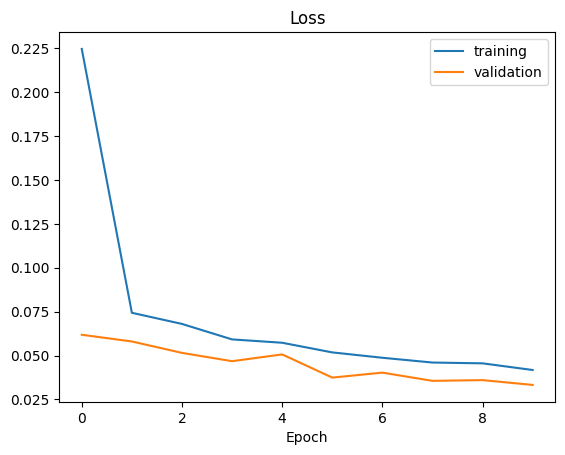

In [184]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [186]:
model.save(filepath="Model/model.h5")

c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
